In [3]:
# LUNEDI: ricontrollare metodo opzioni per taxon con depth maggiore di 7 (taxons di sinonimi, sottospecie, etc.)

# TODO: define method to discriminate if an image is allowed to have questions: to_remove, depth<6...(?)
# - symptom, damage no species questions
# - difficulty, other criteria: frequency
# - use captions

# TODO: use wikipedia edible plants: https://en.wikipedia.org/wiki/Edible_plants to create tags for plants

# Note



- In plants, ignore tags: tag-symptoms, eradicate tags: tag-eradication, if tag-invaded-area ask which WEED is this?
- In protista, ignore all tags baby
- In Bacteria, eradicate tag-adult because just two, tag-damage: difficult questions, maybe we can retrieve the attacked species, tag-diagnostic eradictated!!, tag-egg: eRATICATE

In [4]:
import pandas as pd
from tqdm import tqdm
import requests
import urllib
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
from collections import Counter
import asyncio
import aiohttp
import urllib.parse
from anytree import Node, RenderTree
from random import choice, sample, shuffle

from collections import defaultdict

from PIL import Image, ImageDraw
import requests
from io import BytesIO
import math
from concurrent.futures import ProcessPoolExecutor
from itertools import cycle

import pycountry

- In plants, ignore tags: tag-symptoms, eradicate tags: tag-eradication, if tag-invaded-area ask which WEED is this?
- In protista, ignore all tags baby
- In Bacteria, eradicate tag-adult because just two, tag-damage: difficult questions, maybe we can retrieve the attacked species, tag-diagnostic eradictated!!, tag-egg: eRATICATE

· Plantae
- tag-symptoms: ok
- tag-invaded-area: ask weed identification*
- tag-eradication: remove images

· Protista
- all ok

· Bacteria
- tag-adult: remove images,
- tag-damage: identification is a difficult question, ttry to exploit tags,
- tag-diagnostic: remove images,
- tag-eradication: remove images, 
- tag-larva: remove images, 
- tag-symptoms: ok (seems very good)

· Chromista
- no-tag: ok
- tag-damage: Ask damage cause**
- tag-diagnostic: remove images,
- tag-invaded-are: ok
- tag-symptoms: Ask damage cause

· Animalia
- no-tag: ok (a little noisy)
- tag-adult: Ask growth stage***
- tag-damage: Ask damage cause
- tag-diagnostic: remove images
- tag-egg: ok
- eggs: ok
- tag-eradication : remove images
- taginvaded-area: ok
- 'larva': Ask growth stage
- 'pupa': Ask growth stage
- 'symptoms': Ask damage cause

. Fungi
- no-tag: ok
- tag-damage: Ask damage cause
- tag-diagnostic: remove images
- tag-symptoms: Ask damage cause

virsu
- no-tag: damage cause
- tag-adult: remove_images
- tag-damage: damage cause
- tag-diagnostic: remove images
- tag-eggs: ok
- tag-symptoms: damage cause

new_questions = [*weed_identification, **damage_cause, ***growth_stage]





In [5]:
kingdoms = [
 'Archaea',
 'Bacteria',
 'Chromista',
 'Viruses_and_viroids',
 'Fungi',
 'Protista',
 'Plantae',
 'Animalia']

dfs = {'EPPO':{}, 'GBIF':{}, 'GBIF_unique':{}}

root_dir_eppo = '/workdir/important_datasets/EPPO Dataframes/Kingdom/'
root_dir_gbif = '/workdir/important_datasets/EPPO_to_GBIF/'

for kingdom in kingdoms:
    df_file_path = root_dir_gbif+f'df.{kingdom}_EPPO_to_GBIF.gzip'
    df = pd.read_parquet(df_file_path, engine='pyarrow')
    numeric_cols = df.select_dtypes(include=['number']).columns
    dfs['GBIF'][kingdom] = df.astype({col: 'Int64' for col in numeric_cols})
    #### Merge EPPO Codes
    # Raggruppa le righe per 'key' e considera solo quelle con più di una riga
    dfs['GBIF'][kingdom]['original_order'] = dfs['GBIF'][kingdom].index
    result = (
        dfs['GBIF'][kingdom]
        .groupby('key', as_index=False)
        .agg({
            'EPPO_code': list,  # Aggregate 'code' into lists
            **{col: 'first' for col in dfs['GBIF'][kingdom].columns if col not in ['key', 'EPPO_code']}  # Keep other columns
        })
    )
    dfs['GBIF_unique'][kingdom] = result.sort_values('original_order').drop(columns='original_order')
    
    
    df_file_path = root_dir_eppo+f'df.{kingdom}.EPPO.gzip'
    df = pd.read_parquet(df_file_path, engine='pyarrow')
    numeric_cols = df.select_dtypes(include=['number']).columns
    dfs['EPPO'][kingdom] = df.astype({col: 'Int64' for col in numeric_cols})

FileNotFoundError: [Errno 2] No such file or directory: '/workdir/important_datasets/EPPO_to_GBIF/df.Archaea_EPPO_to_GBIF.gzip'

In [ ]:
# def get_taxonomic_path_row(row):
    
#     if pd.isna(row['key']):
#         return {}
    
#     columns = ['EPPO_code', 'key']
#     new_row = {column: row[column] for column in columns}
#     name = (row.get('canonicalName') if row.get('canonicalName') else row.get('scientificName'))
#     key = row['key']
#     classification_map = (row['higherClassificationMap'])
#     if classification_map:
#         classification_map_dict = eval(row['higherClassificationMap'])
#         classification_map = list(classification_map_dict.items())
#         classification_map += [(str(key), name)]
#         new_row['taxonomic_path'] = classification_map
#     return new_row


# def get_taxonomic_path(df):
#     data = [get_taxonomic_path_row(row) for _, row in df.iterrows()]
#     return pd.DataFrame(data)

# trees={}
# for kingdom in kingdoms:
#     df_paths = get_taxonomic_path(dfs['GBIF'][kingdom])
#     paths = [row['taxonomic_path'] for _, row in df_paths.iterrows() if isinstance(row['taxonomic_path'], list)]
#     root = Node("root")
#     nodes = {}

#     for path in paths:
#         parent = root
#         for node in path:
#             if node not in nodes:
#                 nodes[node] = Node(node, parent=parent)
#             parent = nodes[node]
#     trees[kingdom]=nodes

In [ ]:
to_remove = {
    'Plantae': ['tag-eradication'],
    'Bacteria': ['tag-adult', 'tag-diagnostic', 'tag-eradication', 'tag-larva'],
    'Chromista': ['tag-diagnostic'],
    'Animalia': ['tag-diagnostic', 'tag-eradication'],
    'Fungi': ['tag-diagnostic'],
    'Viruses_and_viroids': ['tag-adult', 'tag-diagnostic']
}

weed_identification =  {
    'Plantae': ['tag-invasive-area']
}

damage_cause =  {
    'Bacteria': ['tag-damage'],
    'Chromista': ['tag-damage','tag-symptoms'],
    'Animalia': ['tag-damage', 'tag-symptoms'],
    'Fungi': ['tag-damage', 'tag-symptoms'],
    'Viruses_and_viroids': ['','tag-damage', 'tag-symptoms']   
}

growth_stage =  {
    'Animalia': ['tag-adult', 'tag-larva', 'tag-pupa'], 
}

In [ ]:
def plot_tag_histogram(count_tags, title):
    """
    Plots a histogram from a dictionary of tag counts.
    
    Parameters:
    - tag_counts (dict): A dictionary where keys are tags and values are their respective counts.
    """
    tags = list(count_tags.keys())
    counts = list(count_tags.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts, color='skyblue', edgecolor='black')
    plt.xlabel('Tags', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def count_tags(EPPO_images):
    count_tags = {kingdom: defaultdict(int) for kingdom in kingdoms}

    for kingdom in kingdoms:
        for image in EPPO_images[kingdom]:
            for tag in image.tag:
                count_tags[kingdom][tag] += 1

    count_tags = {kingdom: dict(value) for kingdom, value in count_tags.items()}
    return count_tags

In [ ]:
def get_kingdom_word(kingdom):
    if kingdom == 'Plantae':
        return 'plant'
    elif kingdom == 'Animalia':
        return 'animal'
    elif kingdom == 'Fungi':
        return 'fungus'
    elif kingdom == 'Bacteria':
        return 'bacterium'
    elif kingdom == 'Archaea':
        return 'archaeon'
    elif kingdom == 'Protista':
        return 'protist'
    elif kingdom == 'Chromista':
        return 'chromist'
    elif kingdom == 'Viruses_and_viroids':
        return 'virus'
    else:
        return

In [ ]:
def update_kwargs(kwargs):
    if 'kingdom' in kwargs:
        kwargs.update({'kingdom_word': get_kingdom_word(kwargs['kingdom'])})
    return kwargs

In [ ]:
def get_common_names(eppo_list, row_gbif):
    languages_gbif=defaultdict(set)
    gbif_cnames=eval(str(row_gbif.get('vernacularNames','[]')))
    eppo_cnames = []
    for row_eppo in eppo_list:
        
        eppo_cnames += eval(str(row_eppo.get('Common names','[]')))
    if gbif_cnames:
        for gbif_cname in gbif_cnames:
            language=gbif_cname.get('language','')
            if language:
                languages_gbif[pycountry.languages.get(alpha_3=language).name].add(gbif_cname['vernacularName'].lower())
    if eppo_cnames:
        for eppo_cname in eppo_cnames:
            value = list(eppo_cname.items())[0][0]
            lang = list(eppo_cname.items())[0][1]
            languages_gbif[lang].add(value)
    return dict(languages_gbif)

def adjust_common_names(row_eppo):
    languages=defaultdict(set)
    for eppo_cname in row_eppo:
        value = list(eppo_cname.items())[0][0]
        lang = list(eppo_cname.items())[0][1]
        languages[lang].add(value)
    return dict(languages)
    

In [ ]:
class EPPOImage():
    def __init__(self, image, taxon, eppo_row):
        self.image_path = image['url']
        self.tag = image['tag']
        self.caption = image['cap']
        self.eppo_row = eppo_row
        self.common_names = adjust_common_names(eval(str(eppo_row.get('Common names','[]'))))
        self.taxon = taxon
    
    def __str__(self):
        # Start by defining the order of attributes
        ordered_attrs = [
            ('Image_path', self.image_path if hasattr(self, 'image_path') else None),
            ('Tag', self.tag),
            ('Caption', self.caption),
        ]

        # Add any other attributes dynamically (if any)
        for attr in dir(self):
            if not callable(getattr(self, attr)) and not attr.startswith("__") and attr not in ['image_path', 'tag', 'caption', 'correct_answer']:
                ordered_attrs.append((attr.capitalize(), getattr(self, attr)))

        # Format and return the string in the correct order
        formatted_attrs = '\n'.join(f"{key}: {value}" for key, value in ordered_attrs if value is not None)
        response = requests.get(self.image_path)
        image = Image.open(BytesIO(response.content))
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels
        plt.show()
        return formatted_attrs
    
    def valid_growth_stage(self):
        growth_stages = ['tag-adult', 'tag-larva', 'tag-pupa', 'tag-egg', 'tag-eggs']
        possible_tag = []
        for tag in self.tag:
            if tag in growth_stages:
                possible_tag.append(tag)
        if len(possible_tag) == 1:
            valid_tag = possible_tag[0][4:] #cut 'tag-' prefix
            if valid_tag.startswith('egg'):
                valid_tag = 'egg'
            return valid_tag
    
    def get_templates(self):
        rank=self.taxon.get_attr('rank')
        kingdom=self.taxon.kingdom
        common_names = self.common_names
        if rank=='GENUS':
            default_templates = {'genus_name'}
        else:
            default_templates = {'scientific_name'}
        if common_names:
            default_templates.add('common_name')    
        for tag in self.tag:
            if tag in to_remove.get(kingdom,[]):
                return {}
            elif tag in weed_identification.get(kingdom,[]):
                return {'weed_identification'}
            elif tag in damage_cause.get(kingdom,[]):
                return {'damage_cause'}
            elif tag in growth_stage.get(kingdom,[]):
                if self.valid_growth_stage():
                    default_templates.add('growth_stage')

        return default_templates

class Taxon():
    def __init__(self, gbif_key, row_eppo, row_gbif, kingdom, index, node=None, trees=[], dfs=dfs, eppo_list=[]):
        self.gbif_key = gbif_key
        #self.taxontree = trees[kingdom]
        self.name  = str(row_gbif.get('canonicalName') if row_gbif.get('canonicalName') else row_gbif.get('scientificName'))
        self.kingdom = kingdom
        self.index = index
        self.df_eppo = dfs['EPPO'][kingdom]
        self.df_gbif = dfs['GBIF'][kingdom]
        self.row_eppo = row_eppo
        self.row_gbif = row_gbif
        self.eppo_list = eppo_list
        self.common_names =get_common_names(eppo_list, row_gbif) # change to eppo_list
        self.node = node
        
    def get_attr(self, attr, fallback=None):
        if pd.isna(self.row_eppo.get(attr)) and pd.isna(self.row_gbif.get(attr)):
            return fallback
        elif self.row_eppo.get(attr):
            return self.row_eppo.get(attr)
        elif self.row_gbif.get(attr):
            return self.row_gbif.get(attr)
        else:
            if fallback is None:
                print('Svegliaaaa attributo inesistente')
            return fallback
    
    # def get_node(self):
    #     key = str(self.get_attr('key'))
    #     name = str(self.get_attr('canonicalName') if self.get_attr('canonicalName') else self.get_attr('scientificName'))
    #     return self.taxontree.get((key, name))
    
    def get_random_neighbors(self, distance, num=3, with_balance_info=False):
        # if not self.get_node():
        #     print(self)
        nodes = get_random_neighbors_node(self.node, distance, num, with_balance_info)
        options = [node.name[1] for node in nodes]
        return  options
             
    def __str__(self):
        return self.get_attr('canonicalName', '')
    
def find_node(key, taxons):
    for tax in taxons:
        if not pd.isna(tax.gbif_key):
            if tax.gbif_key==key:
                return tax

def get_random_neighbors_node(node, distance, num=3, with_balance_info=False):
    if node.depth<=4:
        return []
    
    if node.depth>7:
        distance=distance+1
        max_depth=node.depth+1
        min_depth=7
    else:
        max_depth=node.depth+1
        min_depth=node.depth
    ancestor = node.ancestors[-distance]
    if distance == 0:
        return []
    if distance == 1:
        if len(ancestor.children) - 1 < num:
            return []
        return sample([child for child in ancestor.children if child != node], num)
    
    intermediate_ancestor = node.ancestors[-distance + 1]
    sub_ancestors = [child for child in ancestor.children if child != intermediate_ancestor]
    shuffle(sub_ancestors)
    
    neighbors = []
    sub_ancestor_cycle = cycle(sub_ancestors)  # Cycle through sub_ancestors
    found=0
    
    for sub_ancestor in sub_ancestor_cycle:
        if len(neighbors) >= num or found>len(sub_ancestors):
            break
        descendants = list(descendant for descendant in sub_ancestor.descendants)
        shuffle(descendants)
        for descendant in descendants:
            if min_depth <= descendant.depth <max_depth and descendant not in neighbors:
                neighbors.append(descendant)
                found=0
                break
        found +=1 
        
    
    # if equidistant neighbors is not ensured balanced is False
    if with_balance_info:
        return {'result': neighbors, 'balanced': (len(sub_ancestors) >= num)}
    
    return neighbors    

def get_neighbors_common_names(node, taxons ,distance, kingdom='Plantae',num=3, language=''):
    if node.depth<=4:
        return []
    
    if node.depth>7:
        distance=distance+1
        max_depth=node.depth+1
        min_depth=7
    else:
        max_depth=node.depth+1
        min_depth=node.depth
    ancestor = node.ancestors[-distance]
    if distance == 0:
        return []
    options_names=[]
    if distance == 1:
        if len(ancestor.children) - 1 < num:
            return []
        children=list(ancestor.children)
        shuffle(children)
        for child in children:
            if child != node and len(child.name)==3:
                #print(child.name)
                child_taxon=child.name[-1]
                if child_taxon:
                    names=child_taxon.common_names
                    if language in names:
                        options_names.append(choice(list(names.get(language))))
            if len(options_names)>2:
                return sample(options_names, num)
    
    intermediate_ancestor = node.ancestors[-distance + 1]
    sub_ancestors = [child for child in ancestor.children if child != intermediate_ancestor]
    shuffle(sub_ancestors)
    
    neighbors = []
    sub_ancestor_cycle = cycle(sub_ancestors)  # Cycle through sub_ancestors
    found=0
    
    for sub_ancestor in sub_ancestor_cycle:
        if len(options_names) >= num or found>len(sub_ancestors):
            break
        descendants = list(descendant for descendant in sub_ancestor.descendants)
        shuffle(descendants)
        for descendant in descendants:
            if min_depth <= descendant.depth <max_depth and descendant not in neighbors:
                neighbors.append(descendant)
                descendant_taxon=descendant.name[-1]
                if descendant_taxon and len(descendant.name)==3:
                    names = descendant_taxon.common_names
                    if language in names:
                        options_names.append(choice(list(names.get(language))))
                        found=0
                        break
        found +=1 
    
    return options_names   


In [ ]:
question_templates = {
    'scientific_name':      'What is the scientific name of this {kingdom_word}?',
                        
    'common_name':          'What is the common name in {language} of this {kingdom_word}?',
                        
    'genus_name':           'Which genus does this {kingdom_word} belong to?',
                        
    'major_pest':           'Which of the following is a major pest of this plant?',
        
    'weed_identification':  'What is the scientific name of the invasive weed in this image?',
    
    'damage_cause':         'What is the scientific name of the {kingdom_word} causing this damage?', #tag-symptom, tag-damage
    
    'growth_stage':         'At what growth stage is this {kingdom_word}?',
}

class Question:
    def __init__(self, question='', options=[], correct_answer='', difficulty=0):
        self.correct_answer = correct_answer
        self.options = options
        self.difficulty = difficulty
        self.question = question

    def print_question(self):
        return {
            'question': self.question,
            'options': self.options,
            'correct_answer': self.correct_answer,
            'difficulty': self.difficulty
        }
    
    def __str__(self):
        # Start by defining the order of attributes
        ordered_attrs = [
            ('Kingdom', self.kingdom if hasattr(self, 'kingdom') else None),
            ('Image_path', self.image_path if hasattr(self, 'image_path') else None),
            ('Question', self.question),
            ('Options', self.options),
            ('Correct_answer', self.correct_answer),
        ]

        # Add any other attributes dynamically (if any)
        for attr in dir(self):
            if not callable(getattr(self, attr)) and not attr.startswith("__") and attr not in ['kingdom', 'image_path', 'question', 'options', 'correct_answer']:
                ordered_attrs.append((attr.capitalize(), getattr(self, attr)))

        # Format and return the string in the correct order
        formatted_attrs = '\n'.join(f"{key}: {value}" for key, value in ordered_attrs if value is not None)
        return formatted_attrs

class IdentificationQuestion(Question):
    def __init__(self, tag='', question_template='', options=[], correct_answer='', difficulty=0, image_path='', **kwargs):
        
        self.question_template = question_template
        self.tag = tag
        
        if not self.question_template and self.tag:
            self.question_template = question_templates[self.tag]
            
        self.image_path = image_path
        self.kwargs = kwargs

        
        for key, value in kwargs.items():
            setattr(self, key, value)
        super().__init__(question_template,  options, correct_answer, difficulty)
        
    def update(self, **extra_kwargs):

        self.kwargs.update(extra_kwargs)
        self.kwargs = update_kwargs(self.kwargs)
        self.question = self.question_template.format(**self.kwargs)
        
        for key, value in self.kwargs.items():
            setattr(self, key, value)
        return self       


# Store Taxons and Images

In [ ]:

taxons = {}
EPPO_images = {}

for kingdom in kingdoms:
    encountered_keys = {}
    taxons[kingdom] = []
    EPPO_images[kingdom] = []
    
    for (i,e) , (j,g) in tqdm(zip(dfs['EPPO'][kingdom].iterrows(),dfs['GBIF'][kingdom].iterrows())):
        if pd.isna(g['key']):
            continue 
        key = g['key']
        if key not in encountered_keys:
            #print(e)
            taxon = Taxon(g['key'],e,g,kingdom,j,eppo_list=[e])
            encountered_keys[key] = taxon
            taxons[kingdom].append(taxon)
        else:
            taxon = encountered_keys[key]
            taxon.eppo_list.append(e)
        images = eval(taxon.get_attr('Images', '[]'))
        
        if images:
            for image in images:
                eppo_image = EPPOImage(image, taxon, e)
                EPPO_images[kingdom].append(eppo_image)

13it [00:00, 2411.80it/s]
1029it [00:00, 2868.16it/s]
592it [00:00, 3290.98it/s]
1909it [00:00, 6050.05it/s]
8327it [00:02, 4150.21it/s]
89it [00:00, 4931.93it/s]
58298it [00:16, 3477.03it/s]
27501it [00:06, 3937.75it/s]


In [ ]:
def get_taxonomic_path_row(taxon):
    #eppo_codes = [eppo['EPPO Code'] for eppo in taxon.eppo_list]
    #new_row = {'eppo_list':eppo_codes,'key':taxon.gbif_key}
    
    name = taxon.name
    key = taxon.gbif_key
    
    classification_map = (taxon.get_attr('higherClassificationMap'))
    if classification_map:
        classification_map_dict = eval(classification_map)
        classification_map = list(classification_map_dict.items())
        classification_map += [(str(key), name, taxon)]
    return classification_map

trees={}
for kingdom in tqdm(kingdoms):
    paths=[]
    for taxon in taxons[kingdom]:
        paths.append(get_taxonomic_path_row(taxon))
    
    root = Node("root")
    nodes = {}

    for path in paths:
        parent = root
        for node in path:
            key = node[:2]
            if key not in nodes:
                nodes[key] = Node(node, parent=parent)
            else:
                # If key exists but the current node has a Taxon object, replace it
                existing_node = nodes[key]
                if len(node) > len(existing_node.name):  # Assuming Taxon object makes the tuple longer
                    nodes[key] = Node(node, parent=existing_node.parent)
                    for child in existing_node.children:
                        child.parent = nodes[key]
            parent = nodes[key]
    trees[kingdom]=nodes
    #print('Updating taxon node of', kingdom)
    for taxon in taxons[kingdom]:
        taxon.node = trees[kingdom][(str(taxon.gbif_key),str(taxon.name))]

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


In [ ]:
def get_question(image, question_template, difficulty, num_options=3, language=''):
    
    image_path = image.image_path
    taxon = image.taxon
    if question_template.tag == 'growth_stage':
        
        correct_answer = image.valid_growth_stage()
        if not correct_answer:
            print('No valid growth stage!')
            return
        options = ['egg', 'larva', 'pupa', 'adult']
        
    elif question_template.tag == 'common_name':
        
        correct_answer = choice(list(image.common_names.get(language)))
        options=[]
        options = get_neighbors_common_names(taxon.node,taxons,kingdom=taxon.kingdom, distance=6-difficulty, language=language)
        if len(options) < num_options:
            return
        options.append(correct_answer)
        
    else:
        correct_answer = str(taxon.get_attr('canonicalName') if taxon.get_attr('canonicalName') else taxon.get_attr('scientificName'))
        options = taxon.get_random_neighbors(6-difficulty, num=num_options)
        if len(options) < num_options:
            return
        options.append(correct_answer)
        
    shuffle(options)
    
    question_template.update(options=options, correct_answer=correct_answer, difficulty=difficulty, image_path=image_path, kingdom=taxon.kingdom,language=language)
    
    return question_template

In [ ]:
errors={}
questions={}
c = 0

for kingdom in kingdoms:
    r = 0
    tot=0
    errors[kingdom]={}
    questions[kingdom]={}
    print(kingdom,'TQDMs')
    difficulty=5
    errors[kingdom][difficulty] = 0
    questions[kingdom] = []
    for image in tqdm(EPPO_images[kingdom]):
        templates=image.get_templates()
        for template in templates:
            q_temp = IdentificationQuestion(template)
            if 'English' in list(image.common_names.keys()):
                language = 'English'
            elif list(image.common_names.keys()):
                language=list(image.common_names.keys())[0]
            else:
                language=''
            quest = get_question(image, q_temp, difficulty=difficulty, language=language)
            if quest:
                questions[kingdom].append(quest)

Archaea TQDMs


0it [00:00, ?it/s]


Bacteria TQDMs


100%|██████████| 1910/1910 [00:00<00:00, 6976.35it/s]


Chromista TQDMs


100%|██████████| 330/330 [00:00<00:00, 9141.06it/s]


Viruses_and_viroids TQDMs


100%|██████████| 751/751 [00:00<00:00, 10583.03it/s]


Fungi TQDMs


100%|██████████| 1692/1692 [00:00<00:00, 8483.11it/s]


Protista TQDMs


100%|██████████| 11/11 [00:00<00:00, 9390.87it/s]


Plantae TQDMs


100%|██████████| 6839/6839 [00:01<00:00, 4641.06it/s]


Animalia TQDMs


100%|██████████| 5600/5600 [00:00<00:00, 7112.72it/s]


In [ ]:
c=0
for q in questions['Plantae']:
    if not q.language.startswith('English') and q.tag == 'common_name':
        c+=1
        print(c,q.language)

1 German
2 German
3 Spanish (AR)
4 Spanish (AR)
5 Spanish (AR)
6 Spanish (AR)
7 Spanish (AR)
8 Spanish (AR)
9 Spanish (AR)
10 Spanish (AR)
11 Spanish (AR)
12 Spanish (AR)
13 Spanish (AR)
14 Spanish (AR)
15 Spanish (AR)
16 French
17 French
18 French
19 Indonesian
20 Russian
21 Russian
22 Hebrew
23 Hebrew
24 German
25 German
26 German
27 French
28 French
29 French
30 French
31 German
32 Russian
33 Russian
34 Russian
35 Russian
36 German
37 Russian
38 Russian
39 Russian
40 Russian
41 Russian
42 German
43 German
44 German
45 Hebrew
46 Hebrew
47 Hebrew
48 Hebrew
49 Hebrew
50 Hebrew
51 Hebrew
52 Hebrew
53 Hebrew
54 German
55 German
56 German
57 German
58 French
59 French
60 French
61 French
62 French
63 German
64 German
65 German
66 Italian
67 French
68 French
69 French
70 French
71 Russian
72 Russian
73 Chinese
74 Bulgarian
75 Bulgarian
76 Bulgarian
77 Bulgarian
78 Turkish
79 Turkish
80 German
81 German
82 German
83 German
84 German
85 German
86 German
87 German
88 German
89 German
90 Germa

In [ ]:
def plot_histogram(count_tags, title):
    """
    Plots a histogram from a dictionary of tag counts.
    
    Parameters:
    - tag_counts (dict): A dictionary where keys are tags and values are their respective counts.
    """
    tags = list(count_tags.keys())
    counts = list(count_tags.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts, color='skyblue', edgecolor='black')
    plt.xlabel('', fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

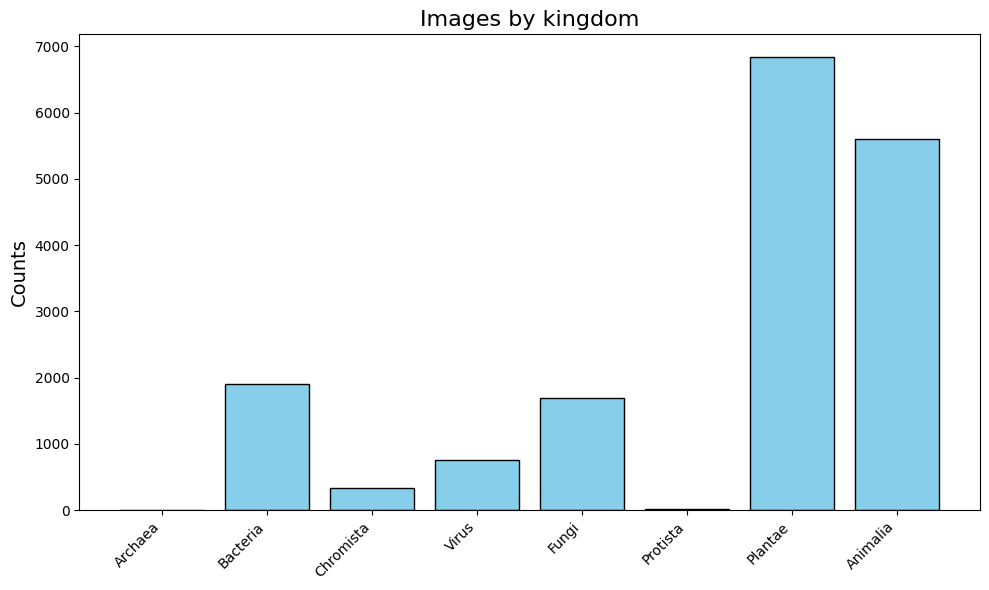

In [ ]:
plot_histogram({k if k != 'Viruses_and_viroids' else 'Virus': len(v) for k, v in EPPO_images.items()}, 'Images by kingdom')

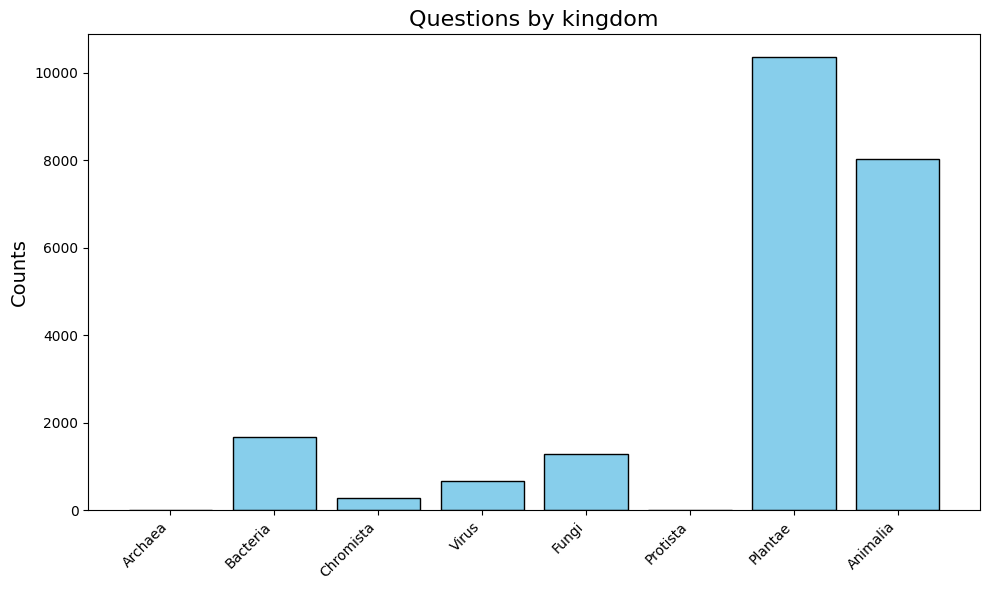

In [ ]:
plot_histogram({k if k != 'Viruses_and_viroids' else 'Virus': len(v) for k, v in questions.items()}, 'Questions by kingdom')

In [ ]:
for question in questions['Plantae']:
    if hasattr(question, 'tag'):
        if question.tag == 'weed_identification':
            print(question)
            break

In [ ]:
errors={}
questions={}
c = 0

for kingdom in kingdoms:
    r = 0
    tot=0
    errors[kingdom]={}
    questions[kingdom]={}
    print(kingdom,'TQDMs')
    for difficulty in range(1,6):
        errors[kingdom][difficulty]=0
        questions[kingdom][difficulty]=[]
        for image in tqdm(EPPO_images[kingdom]):
            templates=image.get_templates()
            for template in templates:
                if template=='genus_name':
                    q_temp = IdentificationQuestion('genus_name')
                    quest = image.get_question(q_temp, difficulty,image=image)#, language='english')
                    questions[kingdom][difficulty].append(quest)

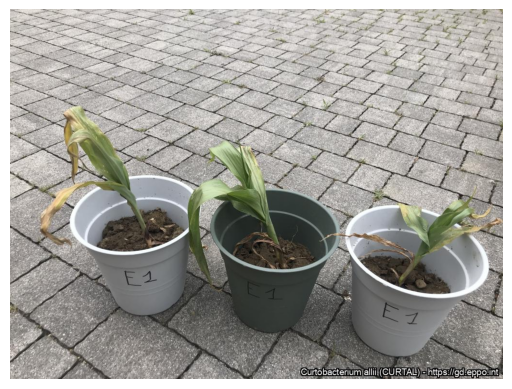

Kingdom: Bacteria
Image_path: https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17130.jpg
Question: Which genus does this bacterium belong to?
Options: ['Tropheryma', 'Microbacterium', 'Curtobacterium', 'Leifsonia']
Correct_answer: Curtobacterium
Difficulty: 5
Image: Image_path: https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17130.jpg
Tag: ['tag-symptoms']
Caption: Symptoms of Curtobacterium allii on Zea mays plants
Taxon: Curtobacterium
Kingdom_word: bacterium
Kwargs: {'options': ['Tropheryma', 'Microbacterium', 'Curtobacterium', 'Leifsonia'], 'correct_answer': 'Curtobacterium', 'difficulty': 5, 'image_path': 'https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17130.jpg', 'kingdom': 'Bacteria', 'image': <__main__.EPPOImage object at 0x7f523b7e1460>, 'kingdom_word': 'bacterium'}
Question_template: Which genus does this {kingdom_word} belong to?
Tag: genus_name


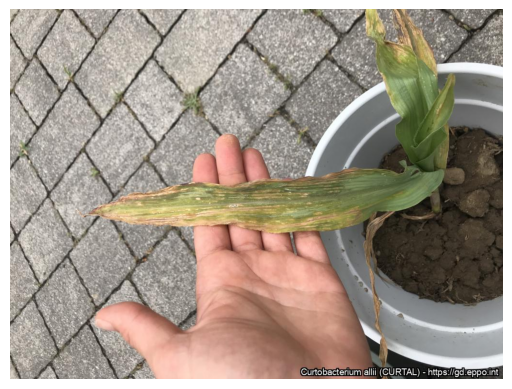

Kingdom: Bacteria
Image_path: https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17129.jpg
Question: Which genus does this bacterium belong to?
Options: ['Agromyces', 'Tropheryma', 'Microbacterium', 'Curtobacterium']
Correct_answer: Curtobacterium
Difficulty: 5
Image: Image_path: https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17129.jpg
Tag: ['tag-symptoms']
Caption: Symptoms of Curtobacterium allii on Zea mays plants
Taxon: Curtobacterium
Kingdom_word: bacterium
Kwargs: {'options': ['Agromyces', 'Tropheryma', 'Microbacterium', 'Curtobacterium'], 'correct_answer': 'Curtobacterium', 'difficulty': 5, 'image_path': 'https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17129.jpg', 'kingdom': 'Bacteria', 'image': <__main__.EPPOImage object at 0x7f523b7f3700>, 'kingdom_word': 'bacterium'}
Question_template: Which genus does this {kingdom_word} belong to?
Tag: genus_name


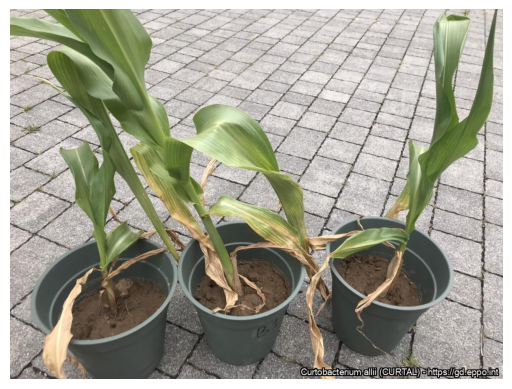

Kingdom: Bacteria
Image_path: https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17128.jpg
Question: Which genus does this bacterium belong to?
Options: ['Curtobacterium', 'Frigoribacterium', 'Microbacterium', 'Agromyces']
Correct_answer: Curtobacterium
Difficulty: 5
Image: Image_path: https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17128.jpg
Tag: ['tag-symptoms']
Caption: Symptoms of Curtobacterium allii on Zea mays plants
Taxon: Curtobacterium
Kingdom_word: bacterium
Kwargs: {'options': ['Curtobacterium', 'Frigoribacterium', 'Microbacterium', 'Agromyces'], 'correct_answer': 'Curtobacterium', 'difficulty': 5, 'image_path': 'https://gd.eppo.int/media/data/taxon/C/CURTAL/pics/1024x0/17128.jpg', 'kingdom': 'Bacteria', 'image': <__main__.EPPOImage object at 0x7f523b7f32e0>, 'kingdom_word': 'bacterium'}
Question_template: Which genus does this {kingdom_word} belong to?
Tag: genus_name


In [ ]:
for q in questions['Bacteria'][5]:
    if q and q.correct_answer != 'Phytoplasma':
        print(q)

In [ ]:
for kingdom in kingdoms:
    print(kingdom)
    for i in range(1, 6):
        print(i, len(questions[kingdom][i]))

Archaea
1 0
2 0
3 0
4 0
5 0
Bacteria
1 821
2 859
3 405
4 798
5 625
Chromista
1 13
2 319
3 330
4 319
5 319
Viruses_and_viroids
1 689
2 422
3 449
4 582
5 674
Fungi
1 1706
2 1658
3 1630
4 1395
5 1222
Protista
1 7
2 7
3 3
4 11
5 0
Plantae
1 5581
2 5511
3 5496
4 5356
5 4758
Animalia
1 5517
2 5517
3 5513
4 5292
5 3688


In [ ]:

# LUNEDI: ricontrollare opzioni per taxon con depth maggiore di 7 (taxons)
node = (7024740, 'Meloidogyne graminicola')
node=(str(node_[0]),str(node_[1]))
def print_taxon(node_):
    node=(str(node_[0]),str(node_[1]))
    print(trees['Animalia'][node].depth)
    ancestor=trees['Animalia'][node].ancestors[-1]
    children = ancestor.children
    print(ancestor.name, ancestor.depth)
    for child in children:
        print('->',child.name,child.depth)
        for des in child.descendants:
            print('->-->',des.name, des.depth)

In [ ]:
for kingdom in kingdoms:
    #plot_tag_histogram(depths[kingdom], f'{kingdom}')

IndentationError: expected an indented block (3488036505.py, line 2)

In [ ]:
async def fetch_image(session, url):
    async with session.get(url) as response:
        if response.status == 200:
            return await response.read()
        else:
            print(f"Failed to fetch image from {url}")
            return None

async def fetch_all_images(urls):
    
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_image(session, url) for url in urls]
        return await asyncio.gather(*tasks)

def process_image(image_data, image_size):
    
    if image_data is None:
        return None
    
    img = Image.open(BytesIO(image_data))
    return img.resize(image_size)

def create_image_grid(images, grid_size=(10, 10), image_size=(100, 100)):
    cols, rows = grid_size
    grid_width = cols * image_size[0]
    grid_height = rows * image_size[1]
    
    grid_image = Image.new("RGB", (grid_width, grid_height), color="white")
    
    for idx, img in enumerate(images):
        if img is None or idx >= cols * rows:
            continue
        
        x = (idx % cols) * image_size[0]
        y = (idx // cols) * image_size[1]
        grid_image.paste(img, (x, y))
    
    grid_image.show()

async def multiprocess(urls, grid_size=(10, 10), image_size=(100, 100)):
    # Step 1: Fetch all images asynchronously
    image_data_list = await fetch_all_images(urls)
    print('All images fetched')
    # Step 2: Use multiprocessing to process images
    with ProcessPoolExecutor(max_workers=32) as executor:
        images = list(executor.map(process_image, image_data_list, [image_size]*len(image_data_list)))
    
    # Step 3: Create and display the image grid
    create_image_grid(images, grid_size=grid_size, image_size=image_size)

async def create_image(urls, number=100):
    cols = int(math.ceil(math.sqrt(number)))
    rows = int(math.ceil(number / cols))
    await multiprocess(urls, grid_size=(cols, rows), image_size=(int(1920/cols), int(1080/rows)))


# Tags

['tag-eggs']
All images fetched


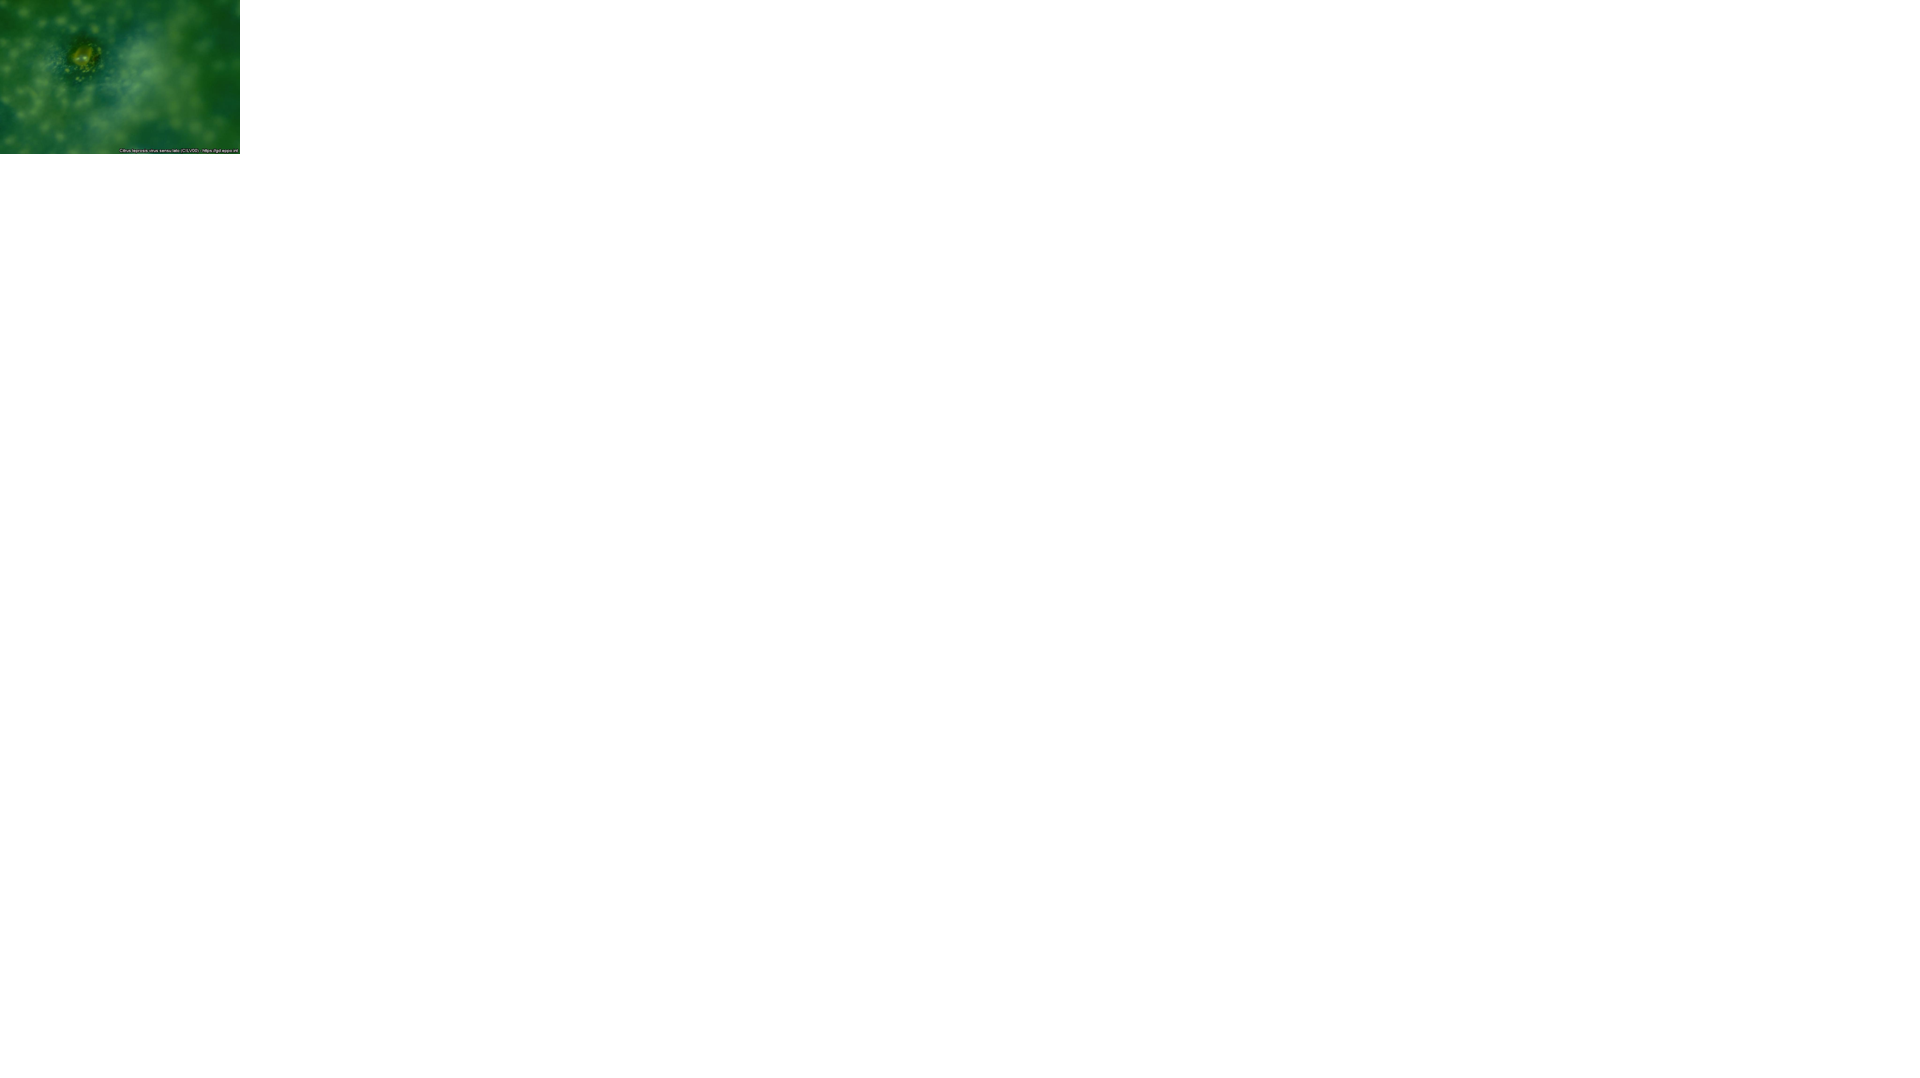

In [ ]:
kingdom = 'Viruses_and_viroids'
tag = 'tag-eggs'
urls = []
captions = []
for image in EPPO_images[kingdom]:
    if tag in image.tag:
    #if len(image.tag)<1:
        print(image.tag)
        urls.append(image.image_path)
        captions.append((image.taxon,image.caption))
len(urls)
await create_image(urls,number=50)